# Football_analysis

In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import requests
from pandasql import sqldf
import pymongo

con = sqlite3.Connection('database.sqlite')
cur = con.cursor()

## Objectives

- The name of the team
- The total number of goals scored by the team during the 2011 season
- The total number of wins the team earned during the 2011 season
- A histogram visualization of the team's wins and losses for the 2011 season (store the visualization directly)
- The team's win percentage on days where it was raining during games in the 2011 season.

## Loading matches table

In [69]:
cur.execute("""Select name
               From sqlite_master 
               Where type="table";""")
print(cur.fetchall())

[('sqlite_sequence',), ('Matches',), ('Teams_in_Matches',), ('Teams',), ('Unique_Teams',)]


In [70]:
cur.execute("""Select * 
               From Matches
;""")
matches_df = pd.DataFrame(cur.fetchall())
matches_df.columns = [x[0] for x in cur.description]

## Using SQL to select season 2011

In [115]:
cur.execute("""Select *
               From Matches
               Where Season == '2011'
               Group By 1
;""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D


## Q1: The name of the team & Q2: The total number of goals scored by the team during the 2011 season

In [93]:
cur.execute("""Select HomeTeam, sum(FTHG)
               From Matches
               Where Season == '2011'
               Group By 1
;""")
hometeam_df = pd.DataFrame(cur.fetchall())
hometeam_df.columns = [x[0] for x in cur.description]
hometeam_df.head()

,HomeTeam,sum(FTHG)
0,Aachen,15
1,Arsenal,39
2,Aston Villa,20
3,Augsburg,20
4,Bayern Munich,49


In [94]:
cur.execute("""Select AwayTeam, sum(FTAG)
               From Matches
               Where Season == '2011'
               Group By 1
;""")
awayteam_df = pd.DataFrame(cur.fetchall())
awayteam_df.columns = [x[0] for x in cur.description]
awayteam_df.head()

,AwayTeam,sum(FTAG)
0,Aachen,15
1,Arsenal,35
2,Aston Villa,17
3,Augsburg,16
4,Bayern Munich,28


In [95]:
total_score_df = pd.concat([hometeam_df.set_index('HomeTeam'), awayteam_df.set_index('AwayTeam')], axis=1, join='inner').reset_index()

total_score_df['total_score'] = total_score_df['sum(FTHG)']+total_score_df['sum(FTAG)']
del total_score_df['sum(FTHG)']
del total_score_df['sum(FTAG)']
total_score_df.rename(columns={'index':'Team'
                          }, 
                 inplace=True)
total_score_df.head()

,Team,total_score
0,Aachen,30
1,Arsenal,74
2,Aston Villa,37
3,Augsburg,36
4,Bayern Munich,77


Text(0.5, 1.0, 'Total score for football team during 2011 season')

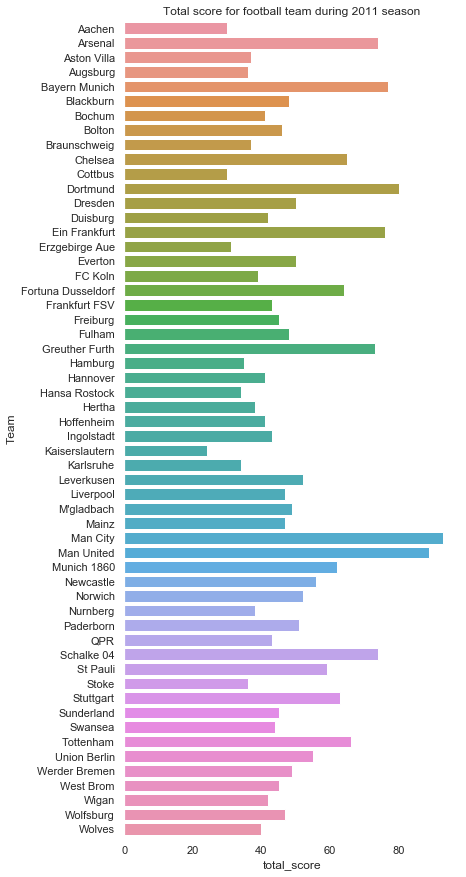

In [109]:
f, ax = plt.subplots(figsize=(6, 15))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.barplot(x="total_score", y="Team", data=total_score_df,
            label="Total_score").set_title('Total score for football team during 2011 season')

### Summary

Man city and Man United have the highest scores during the 2011 season.

## Q3: The total number of wins the team earned during the 2011 season

In [96]:
cur.execute("""Select HomeTeam, Count(FTR)
               From Matches
               Where (Season == '2011')& (FTR =='H')
               Group By 1
;""")
homewin_df = pd.DataFrame(cur.fetchall())
homewin_df.columns = [x[0] for x in cur.description]
homewin_df.head()

,HomeTeam,Count(FTR)
0,Aachen,4
1,Arsenal,12
2,Aston Villa,4
3,Augsburg,6
4,Bayern Munich,14


In [97]:
cur.execute("""Select AwayTeam, Count(FTR)
               From Matches
               Where (Season == '2011')& (FTR =='A')
               Group By 1
;""")
awaywin_df = pd.DataFrame(cur.fetchall())
awaywin_df.columns = [x[0] for x in cur.description]


awaywin_df.rename(columns={'Count(FTR)':'Count2(FTR)'
                          }, 
                 inplace=True)
awaywin_df.head()

,AwayTeam,Count2(FTR)
0,Aachen,2
1,Arsenal,9
2,Aston Villa,3
3,Augsburg,2
4,Bayern Munich,9


In [98]:
total_win_df = pd.concat([homewin_df.set_index('HomeTeam'), awaywin_df.set_index('AwayTeam')], axis=1, join='inner').reset_index()

total_win_df['total_win'] = total_win_df['Count(FTR)']+total_win_df['Count2(FTR)']
del total_win_df['Count(FTR)']
del total_win_df['Count2(FTR)']
total_win_df.rename(columns={'index':'Team'
                          }, 
                 inplace=True)
total_win_df.head()

# pd.concat([df1.set_index('A'),df2.set_index('A')], axis=1, join='inner').reset_index()


,Team,total_win
0,Aachen,6
1,Arsenal,21
2,Aston Villa,7
3,Augsburg,8
4,Bayern Munich,23


Text(0.5, 1.0, 'Total wins for football team during 2011 season')

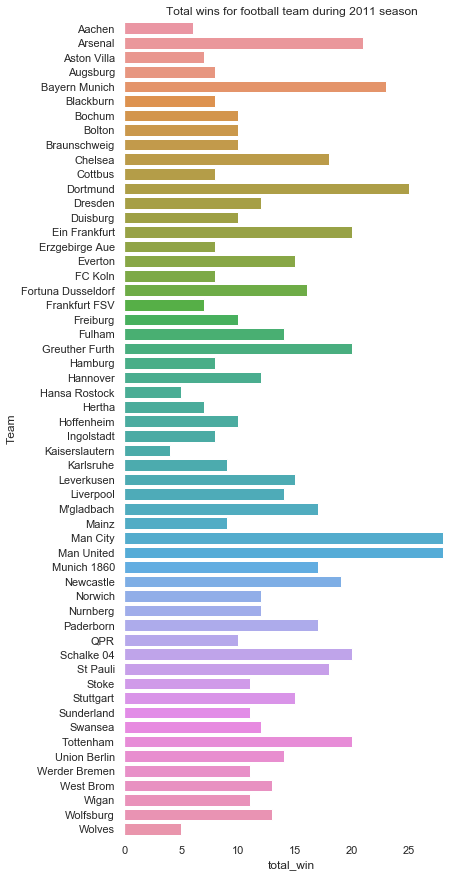

In [110]:
f, ax = plt.subplots(figsize=(6, 15))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.barplot(x="total_win", y="Team", data=total_win_df,
            label="Total_win").set_title('Total wins for football team during 2011 season')

### Summary

Consistently with the total score graph, Man city and Man United have the hight number of wins

## Q4: A histogram visualization of the team's wins and losses for the 2011 season

In [241]:
cur.execute("""Select HomeTeam, Count(FTR)
               From Matches
               Where (Season == '2011')& (FTR =='A')
               Group By 1
;""")
homelose_df = pd.DataFrame(cur.fetchall())
homelose_df.columns = [x[0] for x in cur.description]
homelose_df.head(56)

,HomeTeam,Count(FTR)
0,Aachen,7
1,Arsenal,3
2,Aston Villa,8
3,Augsburg,4
4,Bayern Munich,2
5,Blackburn,12
6,Bochum,7
7,Bolton,11
8,Braunschweig,3
9,Chelsea,4


In [20]:
cur.execute("""Select AwayTeam, Count(FTR)
               From Matches
               Where (Season == '2011')& (FTR =='H')
               Group By 1
;""")
awaylose_df = pd.DataFrame(cur.fetchall())
awaylose_df.columns = [x[0] for x in cur.description]


awaylose_df.rename(columns={'Count(FTR)':'Count2(FTR)'
                          }, 
                 inplace=True)
awaylose_df.head()

,AwayTeam,Count2(FTR)
0,Aachen,8
1,Arsenal,7
2,Aston Villa,6
3,Augsburg,8
4,Bayern Munich,5


In [21]:
result3 = pd.concat([homelose_df.set_index('HomeTeam'), awaylose_df.set_index('AwayTeam')], axis=1, join='inner').reset_index()
result3
result3['total_lose'] = result3['Count(FTR)']+result3['Count2(FTR)']
result3.head()

,index,Count(FTR),Count2(FTR),total_lose
0,Aachen,7,8,15
1,Arsenal,3,7,10
2,Aston Villa,8,6,14
3,Augsburg,4,8,12
4,Bayern Munich,2,5,7


In [24]:
result4 = pd.concat([total_win_df.set_index('Team'), result3.set_index('index')], axis=1, join='inner').reset_index()
result4.head()

,index,total_win,Count(FTR),Count2(FTR),total_lose
0,Aachen,6,7,8,15
1,Arsenal,21,3,7,10
2,Aston Villa,7,8,6,14
3,Augsburg,8,4,8,12
4,Bayern Munich,23,2,5,7


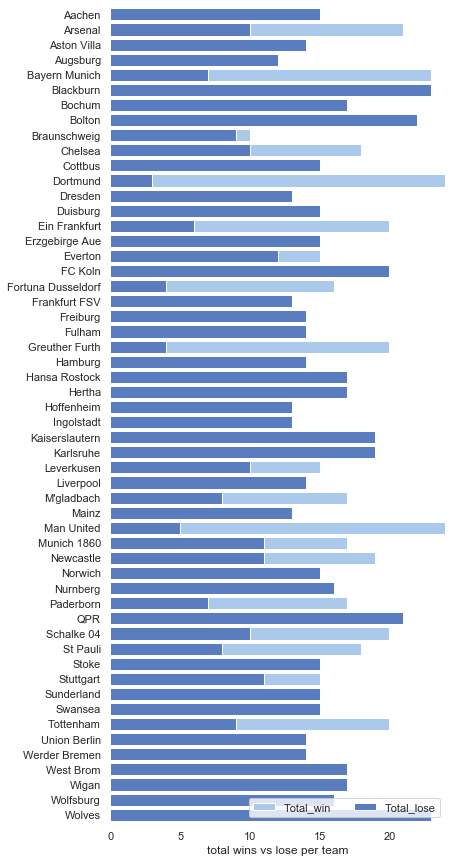

In [181]:
f, ax = plt.subplots(figsize=(6, 15))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set_color_codes("pastel")
sns.barplot(x="total_win", y="index", data=result4,
            label="Total_win", color="b")
sns.set_color_codes("muted")
sns.barplot(x="total_lose", y="index", data=result4,
            label="Total_lose", color="b")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="total wins vs lose per team")
sns.despine(left=True, bottom=True)


### Summary

During the season 2011, few teams have total wins outweights the total lose like Man United, Dortmund. There're other teams like Paderborn and Ein Frankfurt although having more total wins than total loses but they played relately less than most of the teams, therefore the results should be standardized to compare.

## Q5: The team's win percentage on days where it was raining during games in the 2011 season.

In [36]:
df['Date']

0      2012-03-31
1      2011-12-11
2      2011-08-13
3      2011-11-27
4      2012-02-18
          ...    
987    2012-05-13
988    2012-05-13
989    2012-05-13
990    2012-05-13
991    2012-05-13
Name: Date, Length: 992, dtype: object

In [37]:
class Weather_from_dark_sky():
    def __init__(self, path=None, date_list=[]):
        self.date_list = date_list
        self.path = path
    def get_keys(self):
        with open(self.path) as f:
            return json.load(f)
    def get_api(self):
        keys = get_keys(self.path)
        api_key = keys['api_key']
        dfs=[]
        for date in self.date_list:
            latitude = 52.5200
            longitude = 13.4050
            iso_date_time = date + "T00:00:00Z"
            url_template = "https://api.darksky.net/forecast/{}/{},{},{}"
            request_url = url_template.format(
                    api_key,
                    latitude,
                    longitude,
                    iso_date_time)
            response = requests.get(request_url)
            df1 = pd.DataFrame(response.json()["daily"]['data'])
            dfs.append(df1) 
        daily_df=pd.concat(dfs, ignore_index=True)
        return daily_df  

In [38]:
daily = Weather_from_dark_sky("key.json",df['Date'])

In [39]:
daily_df = daily.get_api()
daily_df

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,apparentTemperatureMax,apparentTemperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,cloudCover,dewPoint,...,temperatureMin,temperatureMinTime,time,uvIndex,uvIndexTime,visibility,windBearing,windGust,windGustTime,windSpeed
0,36.34,1333188780,23.96,1333256040,40.06,1333144800,31.84,1333223760,0.71,33.58,...,38.59,1333218000,1333144800,3.0,1.333192e+09,6.174,302,40.29,1.333163e+09,17.31
1,34.94,1323605040,23.68,1323659100,34.94,1323605040,25.47,1323586860,0.56,29.15,...,32.70,1323588960,1323558000,0.0,1.323601e+09,6.212,220,15.03,1.323561e+09,9.66
2,73.67,1313241960,59.00,1313276400,73.67,1313241960,60.54,1313194740,0.56,55.77,...,59.87,1313195400,1313186400,5.0,1.313234e+09,5.803,262,10.02,1.313240e+09,5.37
3,50.77,1322408400,33.91,1322463600,50.77,1322408400,39.79,1322348400,0.73,40.02,...,45.92,1322348400,1322348400,1.0,1.322391e+09,6.216,243,41.17,1.322412e+09,19.56
4,42.45,1329573780,28.71,1329634800,42.45,1329573780,30.32,1329527400,0.79,36.41,...,34.83,1329526920,1329519600,1.0,1.329564e+09,5.508,213,14.99,1.329588e+09,8.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,53.68,1336921500,38.56,1336966740,53.68,1336921500,34.19,1336877820,0.75,36.57,...,38.73,1336878180,1336860000,5.0,1.336907e+09,6.212,294,14.00,1.336860e+09,7.45
988,53.68,1336921500,38.56,1336966740,53.68,1336921500,34.19,1336877820,0.75,36.57,...,38.73,1336878180,1336860000,5.0,1.336907e+09,6.212,294,14.00,1.336860e+09,7.45
989,53.68,1336921500,38.56,1336966740,53.68,1336921500,34.19,1336877820,0.75,36.57,...,38.73,1336878180,1336860000,5.0,1.336907e+09,6.212,294,14.00,1.336860e+09,7.45
990,53.68,1336921500,38.56,1336966740,53.68,1336921500,34.19,1336877820,0.75,36.57,...,38.73,1336878180,1336860000,5.0,1.336907e+09,6.212,294,14.00,1.336860e+09,7.45


In [120]:
daily_df.head()

,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,apparentTemperatureMax,apparentTemperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,cloudCover,dewPoint,...,temperatureMin,temperatureMinTime,time,uvIndex,uvIndexTime,visibility,windBearing,windGust,windGustTime,windSpeed
0,36.34,1333188780,23.96,1333256040,40.06,1333144800,31.84,1333223760,0.71,33.58,...,38.59,1333218000,1333144800,3.0,1.333192e+09,6.174,302,40.29,1.333163e+09,17.31
1,34.94,1323605040,23.68,1323659100,34.94,1323605040,25.47,1323586860,0.56,29.15,...,32.70,1323588960,1323558000,0.0,1.323601e+09,6.212,220,15.03,1.323561e+09,9.66
2,73.67,1313241960,59.00,1313276400,73.67,1313241960,60.54,1313194740,0.56,55.77,...,59.87,1313195400,1313186400,5.0,1.313234e+09,5.803,262,10.02,1.313240e+09,5.37
3,50.77,1322408400,33.91,1322463600,50.77,1322408400,39.79,1322348400,0.73,40.02,...,45.92,1322348400,1322348400,1.0,1.322391e+09,6.216,243,41.17,1.322412e+09,19.56
4,42.45,1329573780,28.71,1329634800,42.45,1329573780,30.32,1329527400,0.79,36.41,...,34.83,1329526920,1329519600,1.0,1.329564e+09,5.508,213,14.99,1.329588e+09,8.17


In [121]:
df['weather'] = daily_df['icon']

In [122]:
df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,weather
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,rain
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A,partly-cloudy-day
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,partly-cloudy-day
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H,wind
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D,partly-cloudy-day


In [60]:
daily_df.to_csv('daily_weather.csv', index=False)

In [123]:
class Rainy_converter():
    def __init__(self, df=[]):
        self.df=df
    def rainy_day(self):
        for i in list(range(0,len(self.df))):
            if (self.df['weather'][i] == 'rain'):
                self.df['weather'][i] = 1
            else:
                self.df['weather'][i] = 0
        return self.df

In [124]:
rainy_convert_df = Rainy_converter(df)

In [125]:
df = rainy_convert_df.rainy_day()
df

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,weather
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,1
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A,0
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,0
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H,0
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D,0
...,...,...,...,...,...,...,...,...,...,...
987,44870,E0,2011,2012-05-13,Sunderland,Man United,0,1,A,0
988,44871,E0,2011,2012-05-13,Swansea,Liverpool,1,0,H,0
989,44872,E0,2011,2012-05-13,Tottenham,Fulham,2,0,H,0
990,44873,E0,2011,2012-05-13,West Brom,Arsenal,2,3,A,0


In [126]:
df.rename(columns={'weather':'rainy'
                          }, 
                 inplace=True)

In [127]:
df

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,rainy
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,1
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A,0
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,0
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H,0
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D,0
...,...,...,...,...,...,...,...,...,...,...
987,44870,E0,2011,2012-05-13,Sunderland,Man United,0,1,A,0
988,44871,E0,2011,2012-05-13,Swansea,Liverpool,1,0,H,0
989,44872,E0,2011,2012-05-13,Tottenham,Fulham,2,0,H,0
990,44873,E0,2011,2012-05-13,West Brom,Arsenal,2,3,A,0


In [37]:
pysqldf = lambda q: sqldf(q, globals())
q1 = "Select HomeTeam, Count(FTR)From df Where (Season == '2011')& (FTR =='H')&(rainy==1) Group By 1;"
q2 = "Select HomeTeam, Count(FTR)From df Where (Season == '2011')& (FTR =='H') Group By 1;"

homewin_rainy_df = pysqldf(q1)
total_homewin_df = pysqldf(q2)

homewin_rainy_df.rename(columns={'Count(FTR)':'Total_win_on_rainy'
                          }, 
                 inplace=True)
homewin_rainy_df.head()

,HomeTeam,Total_win_on_rainy
0,Arsenal,1
1,Augsburg,3
2,Bayern Munich,2
3,Blackburn,1
4,Bochum,1


In [38]:
total_homewin_df
total_homewin_df.rename(columns={'Count(FTR)':'Total_win'
                          }, 
                 inplace=True)
total_homewin_df.head()

,HomeTeam,Total_win
0,Aachen,4
1,Arsenal,12
2,Aston Villa,4
3,Augsburg,6
4,Bayern Munich,14


In [39]:
Hometeam_win = pd.merge(total_homewin_df, homewin_rainy_df, on ='HomeTeam', how='outer')
Hometeam_win.rename(columns={'HomeTeam':'Team'
                          }, 
                 inplace=True)
Hometeam_win

,Team,Total_win,Total_win_on_rainy
0,Aachen,4,NaN
1,Arsenal,12,1.0
2,Aston Villa,4,NaN
3,Augsburg,6,3.0
4,Bayern Munich,14,2.0
5,Blackburn,6,1.0
6,Bochum,7,1.0
7,Bolton,4,NaN
8,Braunschweig,6,2.0
9,Chelsea,12,2.0


In [40]:
Hometeam_win.head()

,Team,Total_win,Total_win_on_rainy
0,Aachen,4,NaN
1,Arsenal,12,1.0
2,Aston Villa,4,NaN
3,Augsburg,6,3.0
4,Bayern Munich,14,2.0


In [41]:
pysqldf = lambda q: sqldf(q, globals())
q_away_1 = "Select AwayTeam, Count(FTR)From df Where (Season == '2011')& (FTR =='A')&(rainy==1) Group By 1;"
q_away_2 = "Select AwayTeam, Count(FTR)From df Where (Season == '2011')& (FTR =='A') Group By 1;"

awaywin_rainy_df = pysqldf(q_away_1)
total_awaywin_df = pysqldf(q_away_2)

awaywin_rainy_df.rename(columns={'Count(FTR)':'Total_win_on_rainy_away'
                          }, 
                 inplace=True)
awaywin_rainy_df.head()

,AwayTeam,Total_win_on_rainy_away
0,Aachen,2
1,Arsenal,2
2,Bayern Munich,3
3,Bochum,1
4,Bolton,3


In [42]:
total_awaywin_df.rename(columns={'Count(FTR)':'Total_win_away'
                          }, 
                 inplace=True)
total_awaywin_df.head()

,AwayTeam,Total_win_away
0,Aachen,2
1,Arsenal,9
2,Aston Villa,3
3,Augsburg,2
4,Bayern Munich,9


In [43]:
Awayteam_win = pd.merge(total_awaywin_df, awaywin_rainy_df, on ='AwayTeam', how='outer')
Awayteam_win.rename(columns={'AwayTeam':'Team'
                          }, 
                 inplace=True)
Awayteam_win.head()

,Team,Total_win_away,Total_win_on_rainy_away
0,Aachen,2,2.0
1,Arsenal,9,2.0
2,Aston Villa,3,NaN
3,Augsburg,2,NaN
4,Bayern Munich,9,3.0


In [44]:
final_rainy_df = pd.merge(Awayteam_win, Hometeam_win, on ='Team', how='outer')

In [45]:
final_rainy_df.head()

,Team,Total_win_away,Total_win_on_rainy_away,Total_win,Total_win_on_rainy
0,Aachen,2,2.0,4,NaN
1,Arsenal,9,2.0,12,1.0
2,Aston Villa,3,NaN,4,NaN
3,Augsburg,2,NaN,6,3.0
4,Bayern Munich,9,3.0,14,2.0


In [46]:
final_rainy_df.fillna(0, inplace = True) 

In [47]:
final_rainy_df.head()

,Team,Total_win_away,Total_win_on_rainy_away,Total_win,Total_win_on_rainy
0,Aachen,2,2.0,4,0.0
1,Arsenal,9,2.0,12,1.0
2,Aston Villa,3,0.0,4,0.0
3,Augsburg,2,0.0,6,3.0
4,Bayern Munich,9,3.0,14,2.0


In [48]:
q_final = "Select Team, (Total_win_on_rainy_away+Total_win_on_rainy)/(Total_win_away + Total_win) From final_rainy_df"

final_df=pysqldf(q_final)
final_df.rename(columns={'(Total_win_on_rainy_away+Total_win_on_rainy)/(Total_win_away + Total_win)':'Win chance on rainy'
                          }, 
                 inplace=True)
final_df

,Team,Win chance on rainy
0,Aachen,0.333333
1,Arsenal,0.142857
2,Aston Villa,0.000000
3,Augsburg,0.375000
4,Bayern Munich,0.217391
5,Blackburn,0.125000
6,Bochum,0.200000
7,Bolton,0.300000
8,Braunschweig,0.400000
9,Chelsea,0.277778


### Summary

For most teams they have low chance to win during the rainy days (<0.5), the best team for rainy days is Munich 1860.

## Change dataframe to dictionary

In [51]:
total_win_dict = total_win_df.to_dict(orient='records') 
total_win_dict

[{'Team': 'Aachen', 'total_win': 6},
 {'Team': 'Arsenal', 'total_win': 21},
 {'Team': 'Aston Villa', 'total_win': 7},
 {'Team': 'Augsburg', 'total_win': 8},
 {'Team': 'Bayern Munich', 'total_win': 23},
 {'Team': 'Blackburn', 'total_win': 8},
 {'Team': 'Bochum', 'total_win': 10},
 {'Team': 'Bolton', 'total_win': 10},
 {'Team': 'Braunschweig', 'total_win': 10},
 {'Team': 'Chelsea', 'total_win': 18},
 {'Team': 'Cottbus', 'total_win': 8},
 {'Team': 'Dortmund', 'total_win': 25},
 {'Team': 'Dresden', 'total_win': 12},
 {'Team': 'Duisburg', 'total_win': 10},
 {'Team': 'Ein Frankfurt', 'total_win': 20},
 {'Team': 'Erzgebirge Aue', 'total_win': 8},
 {'Team': 'Everton', 'total_win': 15},
 {'Team': 'FC Koln', 'total_win': 8},
 {'Team': 'Fortuna Dusseldorf', 'total_win': 16},
 {'Team': 'Frankfurt FSV', 'total_win': 7},
 {'Team': 'Freiburg', 'total_win': 10},
 {'Team': 'Fulham', 'total_win': 14},
 {'Team': 'Greuther Furth', 'total_win': 20},
 {'Team': 'Hamburg', 'total_win': 8},
 {'Team': 'Hannover

In [52]:
total_score_dict = total_score_df.to_dict(orient='records') 
total_score_dict

[{'Team': 'Aachen', 'total_score': 30},
 {'Team': 'Arsenal', 'total_score': 74},
 {'Team': 'Aston Villa', 'total_score': 37},
 {'Team': 'Augsburg', 'total_score': 36},
 {'Team': 'Bayern Munich', 'total_score': 77},
 {'Team': 'Blackburn', 'total_score': 48},
 {'Team': 'Bochum', 'total_score': 41},
 {'Team': 'Bolton', 'total_score': 46},
 {'Team': 'Braunschweig', 'total_score': 37},
 {'Team': 'Chelsea', 'total_score': 65},
 {'Team': 'Cottbus', 'total_score': 30},
 {'Team': 'Dortmund', 'total_score': 80},
 {'Team': 'Dresden', 'total_score': 50},
 {'Team': 'Duisburg', 'total_score': 42},
 {'Team': 'Ein Frankfurt', 'total_score': 76},
 {'Team': 'Erzgebirge Aue', 'total_score': 31},
 {'Team': 'Everton', 'total_score': 50},
 {'Team': 'FC Koln', 'total_score': 39},
 {'Team': 'Fortuna Dusseldorf', 'total_score': 64},
 {'Team': 'Frankfurt FSV', 'total_score': 43},
 {'Team': 'Freiburg', 'total_score': 45},
 {'Team': 'Fulham', 'total_score': 48},
 {'Team': 'Greuther Furth', 'total_score': 73},
 {'

In [131]:
final_dict = final_df.to_dict(orient='records') 
final_dict

[{'Team': 'Aachen', 'Win chance on rainy': 0.3333333333333333},
 {'Team': 'Arsenal', 'Win chance on rainy': 0.14285714285714285},
 {'Team': 'Aston Villa', 'Win chance on rainy': 0.0},
 {'Team': 'Augsburg', 'Win chance on rainy': 0.375},
 {'Team': 'Bayern Munich', 'Win chance on rainy': 0.21739130434782608},
 {'Team': 'Blackburn', 'Win chance on rainy': 0.125},
 {'Team': 'Bochum', 'Win chance on rainy': 0.2},
 {'Team': 'Bolton', 'Win chance on rainy': 0.3},
 {'Team': 'Braunschweig', 'Win chance on rainy': 0.4},
 {'Team': 'Chelsea', 'Win chance on rainy': 0.2777777777777778},
 {'Team': 'Cottbus', 'Win chance on rainy': 0.25},
 {'Team': 'Dortmund', 'Win chance on rainy': 0.2},
 {'Team': 'Dresden', 'Win chance on rainy': 0.25},
 {'Team': 'Duisburg', 'Win chance on rainy': 0.1},
 {'Team': 'Ein Frankfurt', 'Win chance on rainy': 0.1},
 {'Team': 'Erzgebirge Aue', 'Win chance on rainy': 0.125},
 {'Team': 'Everton', 'Win chance on rainy': 0.26666666666666666},
 {'Team': 'FC Koln', 'Win chance o

## Upload dictionary to Mongodb

In [135]:
mydb = myclient['football_database']
mycollection = mydb['total_win_dict']
results = mycollection.insert_many(total_win_dict)
mycollection2 = mydb['total_score_dict']
results2 = mycollection2.insert_many(total_score_dict)
mycollection3 = mydb['final_dict']
results3 = mycollection3.insert_many(final_dict)

In [136]:
query_1 = mycollection3.find({})
for document in query_1:
    print(document)

{'_id': ObjectId('5df25d60a5aab5917b587598'), 'Team': 'Aachen', 'Win chance on rainy': 0.3333333333333333}
{'_id': ObjectId('5df25d60a5aab5917b587599'), 'Team': 'Arsenal', 'Win chance on rainy': 0.14285714285714285}
{'_id': ObjectId('5df25d60a5aab5917b58759a'), 'Team': 'Aston Villa', 'Win chance on rainy': 0.0}
{'_id': ObjectId('5df25d60a5aab5917b58759b'), 'Team': 'Augsburg', 'Win chance on rainy': 0.375}
{'_id': ObjectId('5df25d60a5aab5917b58759c'), 'Team': 'Bayern Munich', 'Win chance on rainy': 0.21739130434782608}
{'_id': ObjectId('5df25d60a5aab5917b58759d'), 'Team': 'Blackburn', 'Win chance on rainy': 0.125}
{'_id': ObjectId('5df25d60a5aab5917b58759e'), 'Team': 'Bochum', 'Win chance on rainy': 0.2}
{'_id': ObjectId('5df25d60a5aab5917b58759f'), 'Team': 'Bolton', 'Win chance on rainy': 0.3}
{'_id': ObjectId('5df25d60a5aab5917b5875a0'), 'Team': 'Braunschweig', 'Win chance on rainy': 0.4}
{'_id': ObjectId('5df25d60a5aab5917b5875a1'), 'Team': 'Chelsea', 'Win chance on rainy': 0.2777777

In [144]:
query_2 = mycollection2.find({})

for document in query_2:
    print(document)

{'_id': ObjectId('5df2594ea5aab5917b587560'), 'Team': 'Aachen', 'total_score': 30}
{'_id': ObjectId('5df2594ea5aab5917b587561'), 'Team': 'Arsenal', 'total_score': 74}
{'_id': ObjectId('5df2594ea5aab5917b587562'), 'Team': 'Aston Villa', 'total_score': 37}
{'_id': ObjectId('5df2594ea5aab5917b587563'), 'Team': 'Augsburg', 'total_score': 36}
{'_id': ObjectId('5df2594ea5aab5917b587564'), 'Team': 'Bayern Munich', 'total_score': 77}
{'_id': ObjectId('5df2594ea5aab5917b587565'), 'Team': 'Blackburn', 'total_score': 48}
{'_id': ObjectId('5df2594ea5aab5917b587566'), 'Team': 'Bochum', 'total_score': 41}
{'_id': ObjectId('5df2594ea5aab5917b587567'), 'Team': 'Bolton', 'total_score': 46}
{'_id': ObjectId('5df2594ea5aab5917b587568'), 'Team': 'Braunschweig', 'total_score': 37}
{'_id': ObjectId('5df2594ea5aab5917b587569'), 'Team': 'Chelsea', 'total_score': 65}
{'_id': ObjectId('5df2594ea5aab5917b58756a'), 'Team': 'Cottbus', 'total_score': 30}
{'_id': ObjectId('5df2594ea5aab5917b58756b'), 'Team': 'Dortmu

In [145]:
query_3 = mycollection.find({})
for document in query_3:
    print(document)

{'_id': ObjectId('5df2592ea5aab5917b587528'), 'Team': 'Aachen', 'total_win': 6}
{'_id': ObjectId('5df2592ea5aab5917b587529'), 'Team': 'Arsenal', 'total_win': 21}
{'_id': ObjectId('5df2592ea5aab5917b58752a'), 'Team': 'Aston Villa', 'total_win': 7}
{'_id': ObjectId('5df2592ea5aab5917b58752b'), 'Team': 'Augsburg', 'total_win': 8}
{'_id': ObjectId('5df2592ea5aab5917b58752c'), 'Team': 'Bayern Munich', 'total_win': 23}
{'_id': ObjectId('5df2592ea5aab5917b58752d'), 'Team': 'Blackburn', 'total_win': 8}
{'_id': ObjectId('5df2592ea5aab5917b58752e'), 'Team': 'Bochum', 'total_win': 10}
{'_id': ObjectId('5df2592ea5aab5917b58752f'), 'Team': 'Bolton', 'total_win': 10}
{'_id': ObjectId('5df2592ea5aab5917b587530'), 'Team': 'Braunschweig', 'total_win': 10}
{'_id': ObjectId('5df2592ea5aab5917b587531'), 'Team': 'Chelsea', 'total_win': 18}
{'_id': ObjectId('5df2592ea5aab5917b587532'), 'Team': 'Cottbus', 'total_win': 8}
{'_id': ObjectId('5df2592ea5aab5917b587533'), 'Team': 'Dortmund', 'total_win': 25}
{'_id

In [143]:
myclient.list_database_names()

['admin', 'config', 'football_database', 'local']

## Upload image to Mongodb

In [180]:
resp = requests.get('https://i.imgur.com/ZtmTlqh.png')

In [157]:
img = resp.content

In [158]:
mycollection4 = mydb['total_win_vs_lose']
results4 = mycollection4.insert_one({'a': 'total_win_vs_lose_figure', 'image': img})


In [165]:
query_4 = mycollection4.find({})
for document in query_4:
    print(document)

{'_id': ObjectId('5df265b9a5aab5917b5875d2'), 'a': 'total_win_vs_lose_figure', 'image': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xc4\x00\x00\x03_\x08\x06\x00\x00\x00Ga\xad\xb6\x00\x00\x00\x04sBIT\x08\x08\x08\x08|\x08d\x88\x00\x00 \x00IDATx\x9c\xec\xddyX\x95\xd5\xfe\xfe\xf1\xf7\x06DM4p\xaa4\xa7\x1c\xd0\x9c\xf2k*9\x83&\xa2\x0c\x8a\xa2\xa6\x91\x98i\x96d6p"E%\xcbSJ\x83c\xa9\xa7\xc1\xf48\xa5n\x19\x1c\x0eV\x98\x9a\x03\x98\rh*\xc7NJ\xa2\x86\x03`\xce\x08\xec\xdf\x1f\xfc\xd8\x81\x0c\xa22m\xb8_\xd7\xd5ud\xefgX\xcf\xc3\xf09k\xedg\xad\xdb`2\x99L\x88\x88\x88TpV\xa5\xdd\x00\x11\x11\x91\xb2@\x05QDD\x04\x15D\x11\x11\x11@\x05QDD\x04PA\x14\x11\x11\x01T\x10EDD\x00\x15D\x11\x11\x11@\x05\xd1b\xa5\xdeL/\xed&\x88X<\xfd\x1eIv\x06M\xcc\xb7\\#\xa7\x7fW\xdaM\x10\xb1h\xabf\xf6.\xed&H\x19\xa2\x1e\xa2\x88\x88\x08*\x88f\xff\xfd\xef\x7fqtt$22\xf2\xae\xf6\x8f\x8e\x8e\xc6\xd7\xd7\xb7\x88[%""%E\x05\xf1\xff3\x1a\x8d\xb8\xba\xba\xb2f\xcd\x9a\xd2n\x8a\x88\x88\x94\x02\x9b\xd2n@Y\x90\x96\x96Fxx8+W\xaed\xc4\x88\x11\x